# Jump detection and height estimation

### Import packages 

In [3]:
import pandas as pd 
import csv
import time
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np

### Load data 

In [39]:

# def load_clean_csv(path):
#     df = pd.read_csv(path, skiprows=1)
    
#     # Remove rows where 'Timestamp' is not a valid number
#     df = df[pd.to_numeric(df['Timestamp'], errors='coerce').notnull()]
    
#     # Convert to float
#     df['Timestamp'] = df['Timestamp'].astype(float)
    
#     return df.reset_index(drop=True)

#Base path
base_path = '/Users/thomasjohnson/Desktop/Sports Tech/CM2024 - Project course/JumpPro'


# Chest sensor
df_chest_acc  = pd.read_csv(f'{base_path}/Jonatan Chest/Acc-2025_04_04-11_32_45.csv', skiprows=1)
df_chest_gyro = pd.read_csv(f'{base_path}/Jonatan Chest/Gyro-2025_04_04-11_32_45.csv', skiprows=1)
df_chest_mag  = pd.read_csv(f'{base_path}/Jonatan Chest/Magn-2025_04_04-11_32_45.csv', skiprows=1)

# Assimilate df_chest dataframes into one dataframe
df_chest = pd.DataFrame(
    { 'Timestamp': df_chest_acc['Timestamp'],
      'AccX': df_chest_acc['AccX'],
      'AccY': df_chest_acc['AccY'],
      'AccZ': df_chest_acc['AccZ'],
      'GyroX': df_chest_gyro['GyroX'],
      'GyroY': df_chest_gyro['GyroY'],
      'GyroZ': df_chest_gyro['GyroZ'],
      'MagX': df_chest_mag['MagnX'],
      'MagY': df_chest_mag['MagnY'],
      'MagZ': df_chest_mag['MagnZ']
    }
)
# Wrist sensor
df_wrist_acc  = pd.read_csv(f'{base_path}/Jonatan Wrist/Acc-2025_04_04-11_32_45.csv', skiprows=1)
df_wrist_gyro = pd.read_csv(f'{base_path}/Jonatan Wrist/Gyro-2025_04_04-11_32_45.csv', skiprows=1)
df_wrist_mag  = pd.read_csv(f'{base_path}/Jonatan Wrist/Magn-2025_04_04-11_32_45.csv', skiprows=1)

df_wrist = pd.DataFrame(
    { 'Timestamp': df_wrist_acc['Timestamp'],
      'AccX_wrist': df_wrist_acc['AccX'],
      'AccY_wrist': df_wrist_acc['AccY'],
      'AccZ_wrist': df_wrist_acc['AccZ'],
      'GyroX_wrist': df_wrist_gyro['GyroX'],
      'GyroY_wrist': df_wrist_gyro['GyroY'],
      'GyroZ_wrist': df_wrist_gyro['GyroZ'],
      'MagX_wrist': df_wrist_mag['MagnX'],
      'MagY_wrist': df_wrist_mag['MagnY'],
      'MagZ_wrist': df_wrist_mag['MagnZ']
    }
)




In [40]:
# Align lengths by truncating the longer dataframe
min_len = min(len(df_chest), len(df_wrist))

# Truncate both dataframes to the minimum length
df_chest = df_chest.iloc[:min_len].reset_index(drop=True)
df_wrist = df_wrist.iloc[:min_len].reset_index(drop=True)

# # Add a common time index
# # Ensure timestamps are numeric before converting to datetime
# df_chest['Timestamp'] = pd.to_numeric(df_chest['Timestamp'], errors='coerce')
# df_chest = df_chest.dropna(subset=['Timestamp'])  # drop bad rows
# df_chest['Time'] = pd.to_datetime(df_chest['Timestamp'], unit='ms')

# df_wrist['Timestamp'] = pd.to_numeric(df_wrist['Timestamp'], errors='coerce')
# df_wrist = df_wrist.dropna(subset=['Timestamp'])  # drop bad rows
# df_wrist['Time'] = pd.to_datetime(df_wrist['Timestamp'], unit='ms')

# df_chest.set_index('Time', inplace=True)
# df_wrist.set_index('Time', inplace=True)

# Merge dataframes on the common time index
df_sync = pd.concat([df_chest, df_wrist], axis=1)


In [41]:
df_sync.head(10)

,Timestamp,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,MagX,MagY,MagZ,Timestamp,AccX_wrist,AccY_wrist,AccZ_wrist,GyroX_wrist,GyroY_wrist,GyroZ_wrist,MagX_wrist,MagY_wrist,MagZ_wrist
0,1743758128.013,-9.475916,2.962420,0.875804,-1.68,9.24,-3.01,-49.999092,40.282463,-107.336571,1743758136.83,4.493881,-3.776009,7.934883,0.91,-1.75,-0.28,62.407127,-103.797234,92.489777
1,1743758128.013,-9.499846,3.005492,0.990664,-1.61,10.43,-4.48,-49.099010,39.597252,-107.464066,1743758136.83,4.603955,-3.752080,7.949241,0.14,-3.64,0.14,59.741192,-99.933456,89.687904
2,1743758128.013,-9.413700,3.034207,1.028950,-1.26,10.43,-4.41,-49.960094,41.610809,-106.540619,1743758136.83,4.536954,-3.723365,7.930098,-0.42,-4.13,0.49,60.905399,-103.841690,89.688240
3,1743758128.013,-9.475916,2.981564,1.033736,-0.49,8.82,-4.06,-49.978935,41.606842,-107.101944,1743758136.83,4.551311,-3.665935,7.901382,-0.63,-3.01,0.63,59.794209,-103.122139,89.683044
4,1743758128.092,-9.423272,2.962420,1.052880,-0.70,7.00,-3.78,-49.922070,37.859406,-109.308662,1743758136.903,4.335949,-3.689864,7.843953,-0.91,-3.36,1.19,59.767700,-101.527802,89.685478
5,1743758128.092,-9.198339,3.048565,1.048094,-2.45,4.76,-2.31,-50.735168,40.923420,-108.479698,1743758136.903,4.489096,-3.555861,7.877453,-1.40,-3.01,0.14,60.914928,-99.319702,91.190697
6,1743758128.092,-9.322770,3.015064,1.024165,-3.01,2.03,-0.70,-51.563717,42.664040,-107.745033,1743758136.903,4.297663,-3.737722,7.858310,-2.03,-2.38,0.14,60.635677,-101.660210,90.917862
7,1743758128.092,-9.241411,3.019850,0.899733,-3.50,2.38,1.19,-51.835297,38.725235,-108.581619,1743758136.903,4.230661,-3.670721,7.877453,-2.87,-3.92,-0.35,62.006390,-101.083763,92.132355
8,1743758128.17,-9.566847,2.675271,0.880590,-1.68,2.31,3.29,-49.932270,41.336884,-106.869736,1743758136.976,4.393379,-3.742508,7.939669,-4.34,-7.77,-0.70,60.224201,-100.269119,90.606468
9,1743758128.17,-9.317985,2.660914,1.005021,5.32,4.20,1.61,-49.021122,37.733944,-107.093964,1743758136.976,4.489096,-3.876511,7.776951,-6.44,-10.36,-2.80,60.224201,-100.269119,90.606468


In [42]:
# Ensure numeric timestamps
df_chest['Timestamp'] = pd.to_numeric(df_chest['Timestamp'], errors='coerce')
df_wrist['Timestamp'] = pd.to_numeric(df_wrist['Timestamp'], errors='coerce')

df_chest.dropna(subset=['Timestamp'], inplace=True)
df_wrist.dropna(subset=['Timestamp'], inplace=True)

# Find wrist start time
wrist_start_time = df_wrist['Timestamp'].iloc[0]

# Trim chest data to start at wrist start time
df_chest_trimmed = df_chest[df_chest['Timestamp'] >= wrist_start_time].copy()

# Trim both dataframes to same length
min_len = min(len(df_chest_trimmed), len(df_wrist))

df_chest_aligned = df_chest_trimmed.iloc[:min_len].reset_index(drop=True)
df_wrist_aligned = df_wrist.iloc[:min_len].reset_index(drop=True)

# Create shared time column starting at t = 0
df_chest_aligned['time'] = (df_chest_aligned['Timestamp'] - wrist_start_time) 
df_wrist_aligned['time'] = (df_wrist_aligned['Timestamp'] - wrist_start_time) 

# Merge for convenience (optional)
df_sync = pd.concat([df_chest_aligned.reset_index(drop=True),
                     df_wrist_aligned.drop(columns=['Timestamp', 'time'])],
                     axis=1)


In [43]:
df_sync.head(10)

,Timestamp,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,MagX,MagY,MagZ,time,AccX_wrist,AccY_wrist,AccZ_wrist,GyroX_wrist,GyroY_wrist,GyroZ_wrist,MagX_wrist,MagY_wrist,MagZ_wrist
0,1.743758e+09,-9.485488,2.876276,0.071787,1.19,6.58,-3.85,-43.433952,35.139660,-90.348404,0.002,4.493881,-3.776009,7.934883,0.91,-1.75,-0.28,62.407127,-103.797234,92.489777
1,1.743758e+09,-9.552489,2.900205,0.057430,1.33,5.67,-3.78,-46.045124,37.415047,-92.310722,0.002,4.603955,-3.752080,7.949241,0.14,-3.64,0.14,59.741192,-99.933456,89.687904
2,1.743758e+09,-9.533346,2.919348,0.062216,-0.28,4.55,-2.59,-43.501209,33.805370,-91.986336,0.002,4.536954,-3.723365,7.930098,-0.42,-4.13,0.49,60.905399,-103.841690,89.688240
3,1.743758e+09,-9.676920,2.943277,0.043072,-1.12,2.45,-1.26,-44.075375,36.561115,-91.353806,0.002,4.551311,-3.665935,7.901382,-0.63,-3.01,0.63,59.794209,-103.122139,89.683044
4,1.743758e+09,-9.533346,2.866704,0.062216,-2.03,1.19,1.40,-44.969860,38.287857,-92.583763,0.081,4.335949,-3.689864,7.843953,-0.91,-3.36,1.19,59.767700,-101.527802,89.685478
5,1.743758e+09,-9.748708,2.866704,-0.009572,-1.54,0.28,3.15,-43.608242,34.622185,-91.700645,0.081,4.489096,-3.555861,7.877453,-1.40,-3.01,0.14,60.914928,-99.319702,91.190697
6,1.743758e+09,-9.676920,2.861918,0.086145,-0.63,1.47,3.36,-43.818031,35.976944,-92.160011,0.081,4.297663,-3.737722,7.858310,-2.03,-2.38,0.14,60.635677,-101.660210,90.917862
7,1.743758e+09,-9.619491,2.909776,0.023929,1.61,2.87,2.59,-43.841152,36.251862,-91.690567,0.081,4.230661,-3.670721,7.877453,-2.87,-3.92,-0.35,62.006390,-101.083763,92.132355
8,1.743758e+09,-9.547704,2.976778,0.038287,2.17,4.48,1.40,-46.114128,34.480465,-94.793068,0.160,4.393379,-3.742508,7.939669,-4.34,-7.77,-0.70,60.224201,-100.269119,90.606468
9,1.743758e+09,-9.614705,2.995921,-0.014357,1.61,3.99,0.28,-45.602753,38.670746,-91.810722,0.160,4.489096,-3.876511,7.776951,-6.44,-10.36,-2.80,60.224201,-100.269119,90.606468


In [44]:
# Estimate sampling frequency
avg_dt = df_sync['time'].diff().dropna().mean()
estimated_hz = 1 / avg_dt
print(f"Estimated sampling rate: {estimated_hz:.2f} Hz")

Estimated sampling rate: 50.80 Hz


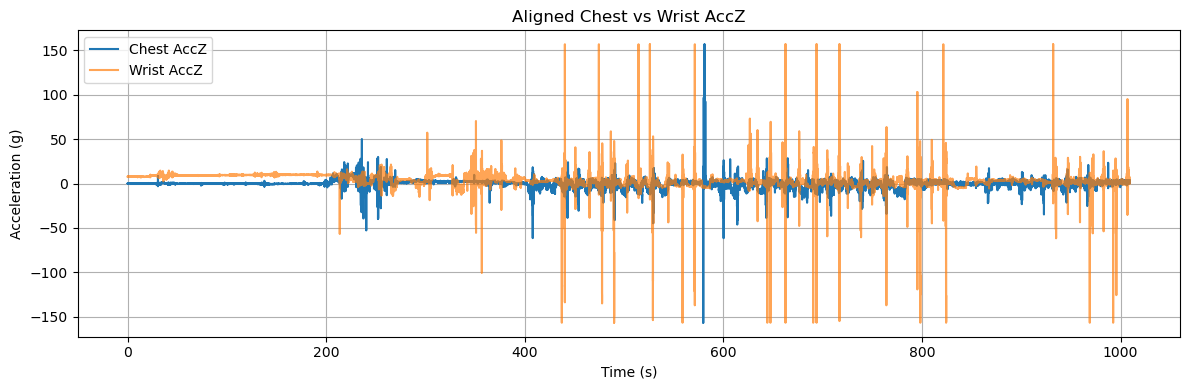

In [45]:
# Check the result
plt.figure(figsize=(12, 4))
plt.plot(df_sync['time'], df_sync['AccZ'], label='Chest AccZ')
plt.plot(df_sync['time'], df_sync['AccZ_wrist'], label='Wrist AccZ', alpha=0.7)
plt.xlabel("Time (s)")
plt.ylabel("Acceleration (g)")
plt.title("Aligned Chest vs Wrist AccZ")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

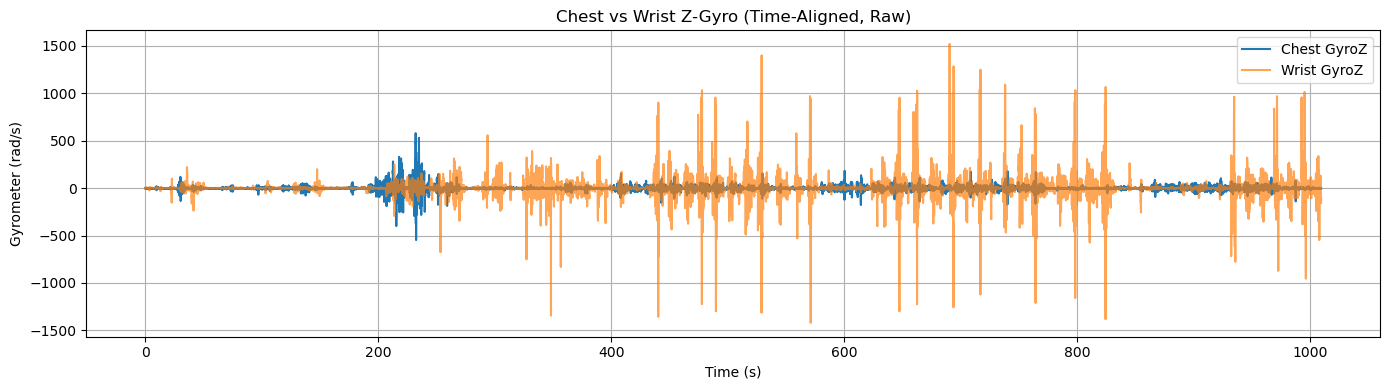

In [46]:
# Visual Sanity Check Gyro
plt.figure(figsize=(14, 4))
plt.plot(df_sync['time'], df_sync['GyroZ'], label='Chest GyroZ')
plt.plot(df_sync['time'], df_sync['GyroZ_wrist'], label='Wrist GyroZ', alpha=0.7) # more transparent
plt.title("Chest vs Wrist Z-Gyro (Time-Aligned, Raw)")
plt.xlabel("Time (s)")
plt.ylabel("Gyrometer (rad/s)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [47]:
print(df_sync['time'].min(), df_sync['time'].max(), len(df_sync))


0.002000093460083008 1009.3210000991821 51276


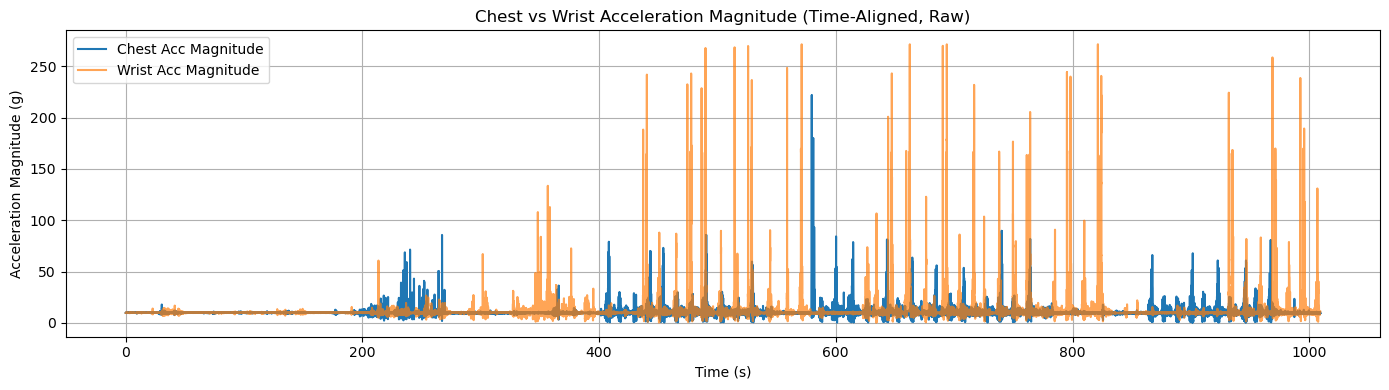

In [48]:
# Sum the x,y,z accelerations to get total acceleration magnitude
df_sync['Acc_Mag'] = np.sqrt(df_sync['AccX']**2 + df_sync['AccY']**2 + df_sync['AccZ']**2)
df_sync['Acc_Mag_wrist'] = np.sqrt(df_sync['AccX_wrist']**2 + df_sync['AccY_wrist']**2 + df_sync['AccZ_wrist']**2)

# Visual Sanity Check Acc Magnitude
plt.figure(figsize=(14, 4))
plt.plot(df_sync['time'], df_sync['Acc_Mag'], label='Chest Acc Magnitude')
plt.plot(df_sync['time'], df_sync['Acc_Mag_wrist'], label='Wrist Acc Magnitude', alpha=0.7) # more transparent
plt.title("Chest vs Wrist Acceleration Magnitude (Time-Aligned, Raw)")
plt.xlabel("Time (s)")
plt.ylabel("Acceleration Magnitude (g)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

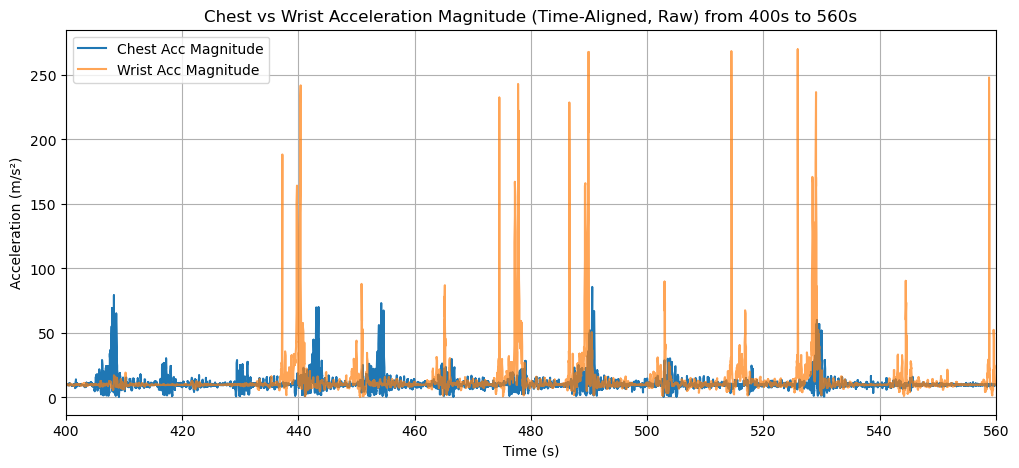

In [49]:
#Plot from 400s to 560s
plt.figure(figsize=(12, 5))
plt.plot(df_sync['time'], df_sync['Acc_Mag'], label='Chest Acc Magnitude')
plt.plot(df_sync['time'], df_sync['Acc_Mag_wrist'], label='Wrist Acc Magnitude', alpha=0.7) # more transparent
plt.title("Chest vs Wrist Acceleration Magnitude (Time-Aligned, Raw) from 400s to 560s")
plt.xlim(400, 560)  # Adjust x-axis limits to zoom in
plt.xlabel('Time (s)')
plt.ylabel('Acceleration (m/s²)')
plt.legend()
plt.grid(True)
plt.show()

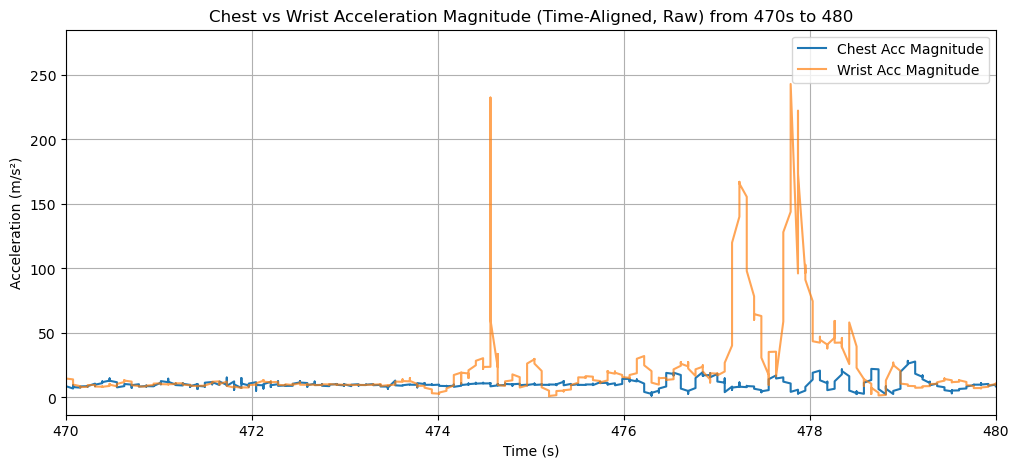

In [50]:
#Plot from 470s to 480s
plt.figure(figsize=(12, 5))
plt.plot(df_sync['time'], df_sync['Acc_Mag'], label='Chest Acc Magnitude')
plt.plot(df_sync['time'], df_sync['Acc_Mag_wrist'], label='Wrist Acc Magnitude', alpha=0.7) # more transparent
plt.title("Chest vs Wrist Acceleration Magnitude (Time-Aligned, Raw) from 470s to 480")
plt.xlim(470, 480)  # Adjust x-axis limits to zoom in
plt.xlabel('Time (s)')
plt.ylabel('Acceleration (m/s²)')
plt.legend()
plt.grid(True)
plt.show()

In [52]:
from scipy.signal import butter, filtfilt

rect_acc_chest = df_sync['Acc_Mag']
rect_acc_wrist = df_sync['Acc_Mag_wrist']

# Low-pass filter setup
def butter_lowpass_filter(data, cutoff=0.5, fs=50, order=4):
    nyq = 0.5 * fs
    norm_cutoff = cutoff / nyq
    b, a = butter(order, norm_cutoff, btype='low', analog=False)
    return filtfilt(b, a, data)

filtered_acc_chest = butter_lowpass_filter(rect_acc_chest, cutoff=0.5, fs=estimated_hz)
filtered_acc_wrist = butter_lowpass_filter(rect_acc_wrist, cutoff=0.5, fs=estimated_hz)

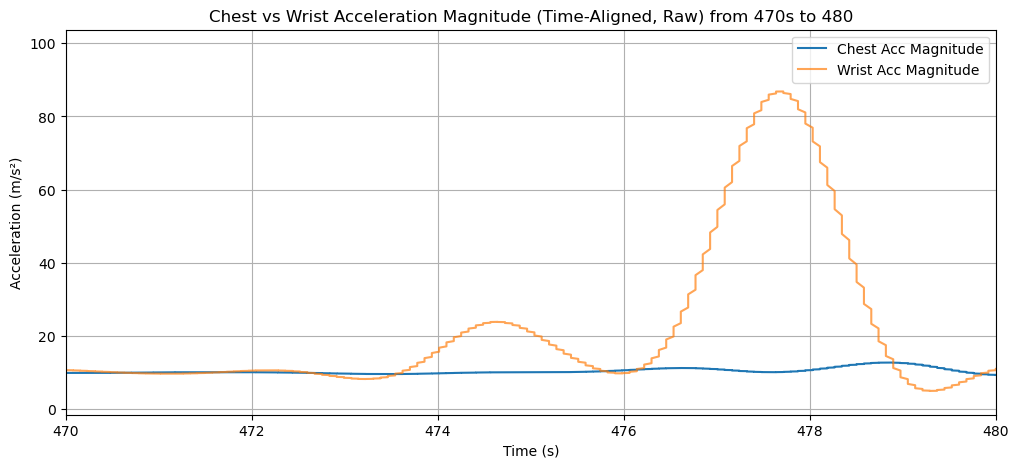

In [53]:
#Plot from 470s to 480s
plt.figure(figsize=(12, 5))
plt.plot(df_sync['time'], filtered_acc_chest, label='Chest Acc Magnitude')
plt.plot(df_sync['time'], filtered_acc_wrist, label='Wrist Acc Magnitude', alpha=0.7) # more transparent
plt.title("Chest vs Wrist Acceleration Magnitude (Time-Aligned, Raw) from 470s to 480")
plt.xlim(470, 480)  # Adjust x-axis limits to zoom in
plt.xlabel('Time (s)')
plt.ylabel('Acceleration (m/s²)')
plt.legend()
plt.grid(True)
plt.show()

In [209]:
df_sync.to_csv('synchronized_data.csv', index=False)

### Madgwick filter - imufusion

In [229]:

import imufusion

# # read back in synchronized data as df_sync
# df_sync = pd.read_csv('synchronized_data.csv')

# # Prepare data for processing
timestamp = df_sync['time'].to_numpy()  # seconds
gyroscope_s = df_sync[['GyroX', 'GyroY', 'GyroZ']].to_numpy()
accelerometer = df_sync[['AccX', 'AccY', 'AccZ']].to_numpy()
magnetometer = df_sync[['MagX', 'MagY', 'MagZ']].to_numpy()
# gyroscope_s   = df_sync[["GyroX_wrist","GyroY_wrist","GyroZ_wrist"]].to_numpy()  # deg/s
# accelerometer = df_sync[["AccX_wrist","AccY_wrist","AccZ_wrist"]].to_numpy()     # g
# magnetometer  = df_sync[["MagX_wrist","MagY_wrist","MagZ_wrist"]].to_numpy()     # uT 

# Sampling and delta time
dt = np.diff(timestamp, prepend=timestamp[0])

# Replace any zeros/negatives just in case of edge effects
# Estimate sampling rate
time_diffs = df_sync['time'].diff().dropna()
avg_dt = time_diffs.mean()           # average dt (seconds)
sample_rate_est = 1 / avg_dt         # Hz

print(f"Estimated sample rate: {sample_rate_est:.2f} Hz")

# Explicit cast to Python int
offset = imufusion.Offset(int(round(sample_rate_est)))
ahrs = imufusion.Ahrs()
ahrs.settings = imufusion.Settings(
    imufusion.CONVENTION_NWU,  # frame convention
    0.5,                       # gain
    2000,                      # gyro range (deg/s)
    10,                        # accel rejection
    10,                        # mag rejection
    int(5 * sample_rate_est),  # recovery trigger period in samples (~5 s)
)

# Preallocate outputs
n = len(timestamp)
euler_deg       = np.empty((n, 3))
gyro_global     = np.empty_like(gyroscope_s)
accel_global    = np.empty_like(accelerometer)
mag_global      = np.empty_like(magnetometer)
flags           = np.empty((n, 4), dtype=int)
internal_states = np.empty((n, 6))

# Run filter + rotate to global frame each step
for i in range(len(timestamp)):
    gyroscope_s[i] = offset.update(gyroscope_s[i])
    ahrs.update(gyroscope_s[i], accelerometer[i], magnetometer[i], dt[i])

    # # Rotate raw sensor vectors into the global frame - DOES NOT WORK
    # gyro_global[i]  = ahrs.quaternion.vector(gyroscope_s[i])
    # accel_global[i] = ahrs.quaternion.vector(accelerometer[i])
    # mag_global[i]   = ahrs.quaternion.vector(magnetometer[i])

    # Orientation → Euler
    euler_deg[i] = ahrs.quaternion.to_euler()  # [roll, pitch, yaw] degrees

    # Optional diagnostics
    ist = ahrs.internal_states
    internal_states[i] = np.array([
        ist.acceleration_error,
        ist.accelerometer_ignored,
        ist.acceleration_recovery_trigger,
        ist.magnetic_error,
        ist.magnetometer_ignored,
        ist.magnetic_recovery_trigger,
    ])
    fl = ahrs.flags
    flags[i] = np.array([fl.initialising, fl.angular_rate_recovery, fl.acceleration_recovery, fl.magnetic_recovery])

# Build output DataFrame
df_madgwick = pd.DataFrame({
    "time": timestamp,
    # Euler angles chest
    "roll_deg_chest":  euler_deg[:,0],
    "pitch_deg_chest": euler_deg[:,1],
    "yaw_deg_chest":   euler_deg[:,2],
    # Global-frame chest signals
    "GyroX_chest_global": gyro_global[:,0],
    "GyroY_chest_global": gyro_global[:,1],
    "GyroZ_chest_global": gyro_global[:,2],
    "AccX_chest_global":  accel_global[:,0],
    "AccY_chest_global":  accel_global[:,1],
    "AccZ_chest_global":  accel_global[:,2],
    "MagX_chest_global":  mag_global[:,0],
    "MagY_chest_global":  mag_global[:,1],
    "MagZ_chest_global":  mag_global[:,2],
    # # Euler angles wrist
    # "roll_deg_wrist":  euler_deg[:,0],
    # "pitch_deg_wrist": euler_deg[:,1],
    # "yaw_deg_wrist":   euler_deg[:,2],
    # # Global-frame wrist signals
    # "GyroX_wrist_global": gyro_global[:,0],
    # "GyroY_wrist_global": gyro_global[:,1],
    # "GyroZ_wrist_global": gyro_global[:,2],
    # "AccX_wrist_global":  accel_global[:,0],
    # "AccY_wrist_global":  accel_global[:,1],
    # "AccZ_wrist_global":  accel_global[:,2],
    # "MagX_wrist_global":  mag_global[:,0],
    # "MagY_wrist_global":  mag_global[:,1],
    # "MagZ_wrist_global":  mag_global[:,2],
    # # Flags (optional)
    # "flag_initialising":          flags[:,0],
    # "flag_angrate_recovery":      flags[:,1],
    # "flag_accel_recovery":        flags[:,2],
    # "flag_magnetic_recovery":     flags[:,3],
    # "accel_err_deg":              internal_states[:,0],
    # "accel_ignored":              internal_states[:,1],
    # "accel_recovery_trigger":     internal_states[:,2],
    # "mag_err_deg":                internal_states[:,3],
    # "mag_ignored":                internal_states[:,4],
    # "mag_recovery_trigger":       internal_states[:,5],
})



Estimated sample rate: 50.80 Hz


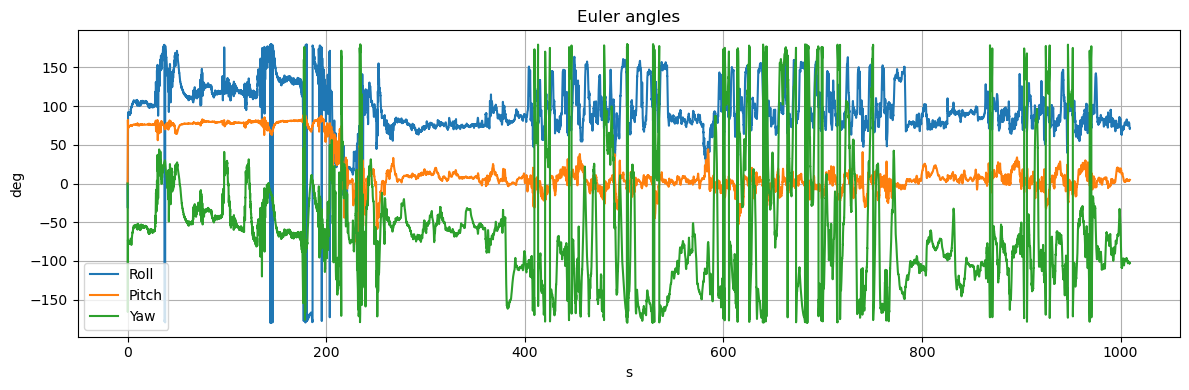

In [230]:
# Quick sanity plot
plt.figure(figsize=(12,4))
# plt.plot(df_madgwick["time"], df_madgwick["roll_deg_wrist"],  label="Roll")
# plt.plot(df_madgwick["time"], df_madgwick["pitch_deg_wrist"], label="Pitch")
# plt.plot(df_madgwick["time"], df_madgwick["yaw_deg_wrist"],   label="Yaw")
plt.plot(df_madgwick["time"], df_madgwick["roll_deg_chest"],  label="Roll")
plt.plot(df_madgwick["time"], df_madgwick["pitch_deg_chest"], label="Pitch")
plt.plot(df_madgwick["time"], df_madgwick["yaw_deg_chest"],   label="Yaw")
plt.ylabel("deg"); plt.xlabel("s"); plt.title("Euler angles"); plt.grid(True); plt.legend(); plt.tight_layout(); plt.show()


In [231]:
df_madgwick.head()

,time,roll_deg_chest,pitch_deg_chest,yaw_deg_chest,GyroX_chest_global,GyroY_chest_global,GyroZ_chest_global,AccX_chest_global,AccY_chest_global,AccZ_chest_global,MagX_chest_global,MagY_chest_global,MagZ_chest_global
0,0.002,0.000000,0.000000,0.000000,0.0,74.447273,92.354034,-9.485488,2.876276,0.071787,-43559.813991,3371.984998,1.198769e-71
1,0.002,0.000000,0.000000,0.000000,0.0,7.680083,4.629972,-9.552489,2.900205,0.057430,88.548122,89.095965,7.110588e-38
2,0.002,0.000000,0.000000,0.000000,0.0,-52.807018,163.457077,-9.533346,2.919348,0.062216,-43559.813991,3371.984998,4.462305e-86
3,0.002,0.000000,0.000000,0.000000,0.0,74.447289,92.354042,-9.676920,2.943277,0.043072,88.580342,89.174430,5.150575e-62
4,0.081,-13.620091,31.436552,-78.989952,0.0,7.680085,4.629973,-9.533346,2.866704,0.062216,-43559.813991,3379.239005,1.085785e-95


In [247]:
## Save for reuse
df_madgwick.to_csv("df_madgwick_jonatan_chest.csv", index=False)
# df_madgwick.to_csv("df_madgwick_jonatan_w.csv", index=False)
# df_madgwick.to_csv("df_madgwick_david_c.csv", index=False)
# df_madgwick.to_csv("df_madgwick_david_w.csv", index=False)

### Import post-madgwick

In [29]:
# # import madgwick filtered data 
subject = "jonatan"
# subject = "david"
location = "chest" 
# location = "wrist"


df_mad_jonatan_chest = pd.read_csv(f'df_madgwick_{subject}_{location}.csv')
# df_mad_jonatan_wrist = pd.read_csv('df_madgwick_jonatan_w.csv')

#Load df_sync 
df_sync = pd.read_csv('df_sync.csv')

### Plotting

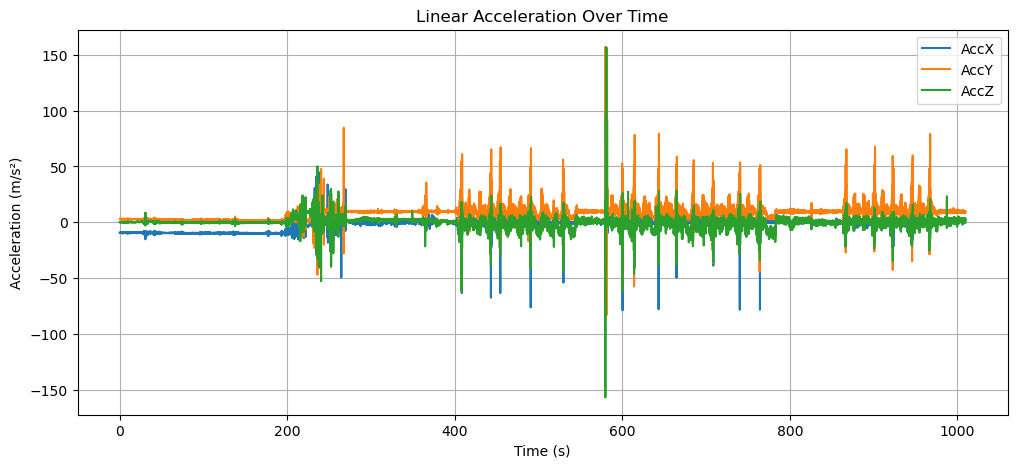

In [6]:
plt.figure(figsize=(12, 5))
plt.plot(df_mad_jonatan_chest['time'], df_mad_jonatan_chest['AccX_chest_global'], label='AccX')
plt.plot(df_mad_jonatan_chest['time'], df_mad_jonatan_chest['AccY_chest_global'], label='AccY')
plt.plot(df_mad_jonatan_chest['time'], df_mad_jonatan_chest['AccZ_chest_global'], label='AccZ')
# plt.plot(df_madgwick['time'], df_madgwick['AccX_wrist_global'], label='AccX')
# plt.plot(df_madgwick['time'], df_madgwick['AccY_wrist_global'], label='AccY')
# plt.plot(df_madgwick['time'], df_madgwick['AccZ_wrist_global'], label='AccZ')
plt.title('Linear Acceleration Over Time')
plt.xlabel('Time (s)')
plt.ylabel('Acceleration (m/s²)')
plt.legend()
plt.grid(True)
plt.show()


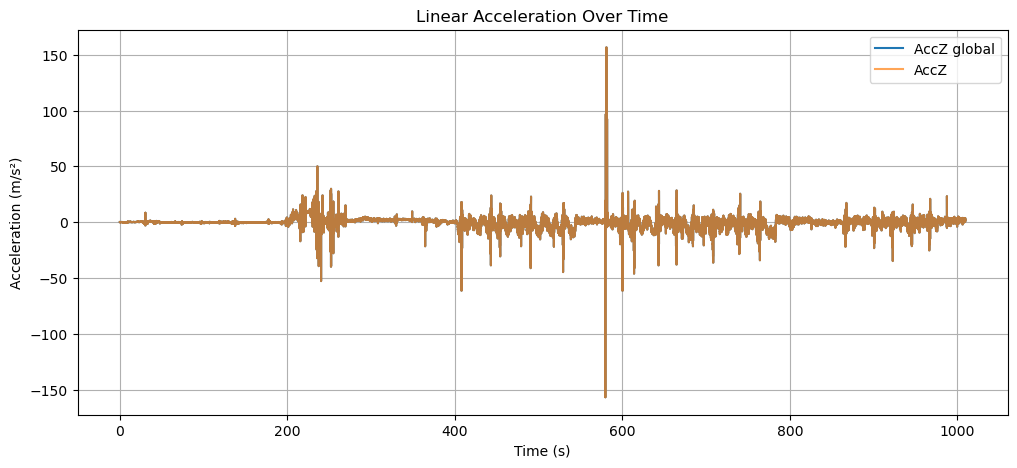

In [30]:
#Compare Madgwick and raw vertical acceleration
plt.figure(figsize=(12, 5))
plt.plot(df_mad_jonatan_chest['time'], df_mad_jonatan_chest['AccZ_chest_global'], label='AccZ global')
plt.plot(df_sync['time'], df_sync['AccZ'], label='AccZ', alpha=0.7)
plt.title('Linear Acceleration Over Time')
plt.xlabel('Time (s)')
plt.ylabel('Acceleration (m/s²)')
plt.legend()
plt.grid(True)
plt.show()

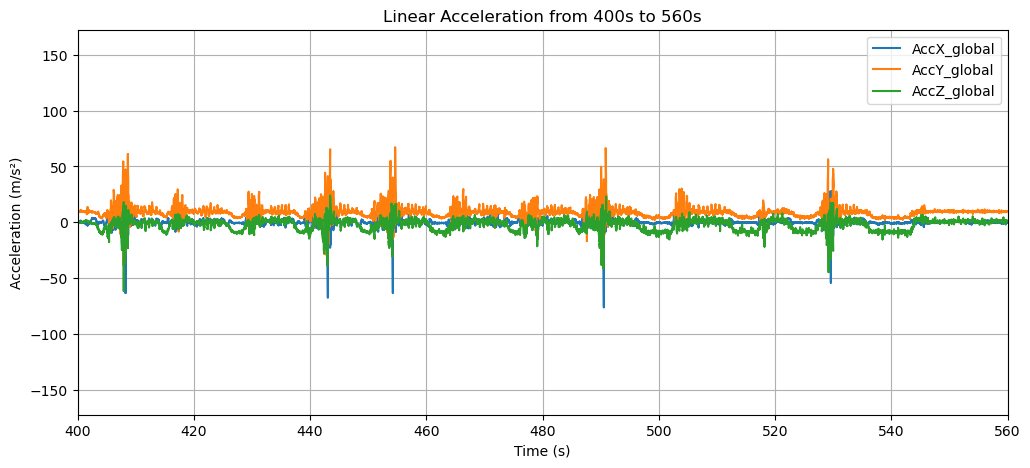

In [8]:
#Plot from 400s to 560s
plt.figure(figsize=(12, 5))
plt.plot(df_mad_jonatan_chest['time'], df_mad_jonatan_chest['AccX_chest_global'], label='AccX_global')
plt.plot(df_mad_jonatan_chest['time'], df_mad_jonatan_chest['AccY_chest_global'], label='AccY_global')
plt.plot(df_mad_jonatan_chest['time'], df_mad_jonatan_chest['AccZ_chest_global'], label='AccZ_global')
plt.xlim(400, 560)  # Adjust x-axis limits to zoom in
# plt.ylim(-500, 500)  # Adjust y-axis limits if needed
plt.title('Linear Acceleration from 400s to 560s')
plt.xlabel('Time (s)')
plt.ylabel('Acceleration (m/s²)')
plt.legend()
plt.grid(True)
plt.show()

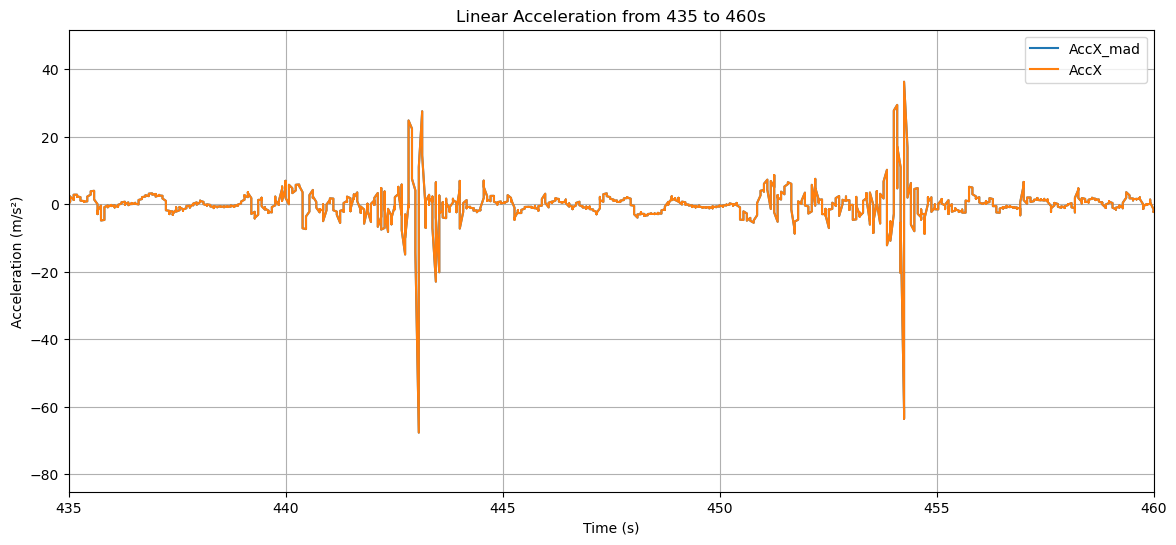

In [35]:
#Plot from 435s to 460s
plt.figure(figsize=(14, 6))
plt.plot(df_mad_jonatan_chest['time'], df_mad_jonatan_chest['AccX_chest_global'], label='AccX_mad')
plt.plot(df_sync['time'], df_sync['AccX'], label='AccX')
plt.xlim(435, 460)  # Adjust x-axis limits to zoom in
# plt.ylim(-500, 500)  # Adjust y-axis limits 
plt.title('Linear Acceleration from 435 to 460s')
plt.xlabel('Time (s)')
plt.ylabel('Acceleration (m/s²)')
plt.legend()
plt.grid(True)
plt.show()

### Filtering

In [65]:
from scipy.signal import butter, filtfilt

# Low-pass filter setup
def butter_lowpass_filter(data, cutoff=1, fs=50, order=4):
    nyq = 0.5 * fs
    norm_cutoff = cutoff / nyq
    b, a = butter(order, norm_cutoff, btype='low', analog=False)
    return filtfilt(b, a, data)

filtered_accX_ch = butter_lowpass_filter(df_mad_jonatan_chest['AccX_chest_global'])/9.81
filtered_accY_ch = butter_lowpass_filter(df_mad_jonatan_chest['AccY_chest_global'])/9.81
filtered_accZ_ch = butter_lowpass_filter(df_mad_jonatan_chest['AccZ_chest_global'])/9.81 # convert to g
# filtered_accX_wr = butter_lowpass_filter(df_mad_jonatan_wrist['AccX_wrist'] , cutoff=10, fs=sample_rate)
# filtered_accY_wr = butter_lowpass_filter(df_mad_jonatan_wrist['AccY_wrist'] , cutoff=10, fs=sample_rate)
# filtered_accZ_wr = butter_lowpass_filter(df_mad_jonatan_wrist['AccZ_wrist'] , cutoff=10, fs=sample_rate)

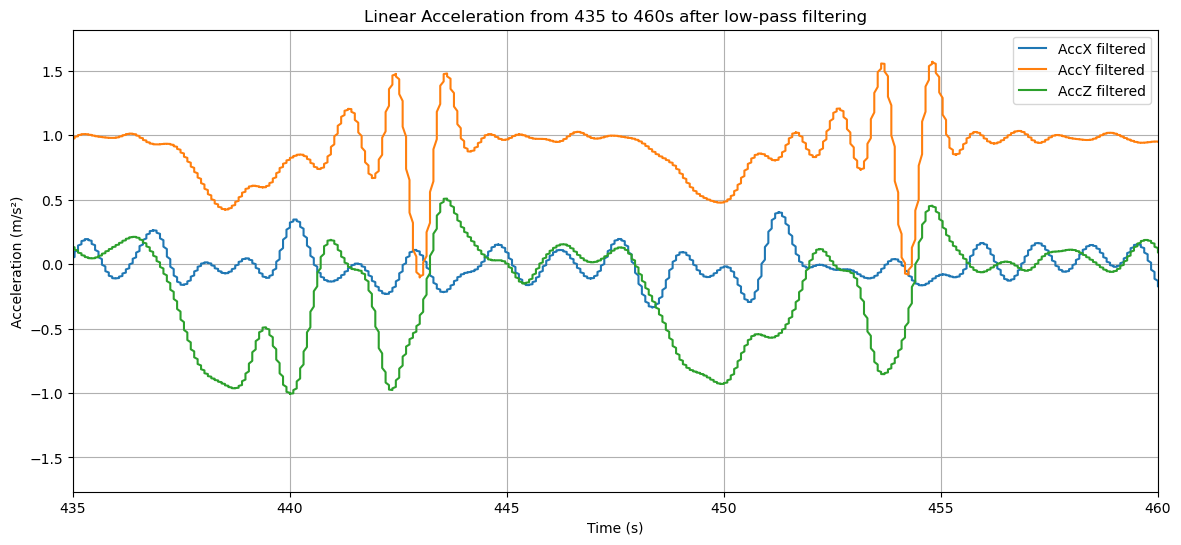

In [66]:
#Plot from 435s to 460s
plt.figure(figsize=(14, 6))
plt.plot(df_mad_jonatan_chest['time'], filtered_accX_ch, label='AccX filtered')
plt.plot(df_mad_jonatan_chest['time'], filtered_accY_ch, label='AccY filtered')
plt.plot(df_mad_jonatan_chest['time'], filtered_accZ_ch, label='AccZ filtered')
plt.xlim(435, 460)  # Adjust x-axis limits to zoom in
# plt.ylim(-500, 500)  # Adjust y-axis limits 
plt.title('Linear Acceleration from 435 to 460s after low-pass filtering')
plt.xlabel('Time (s)')
plt.ylabel('Acceleration (m/s²)')
plt.legend()
plt.grid(True)
plt.show()

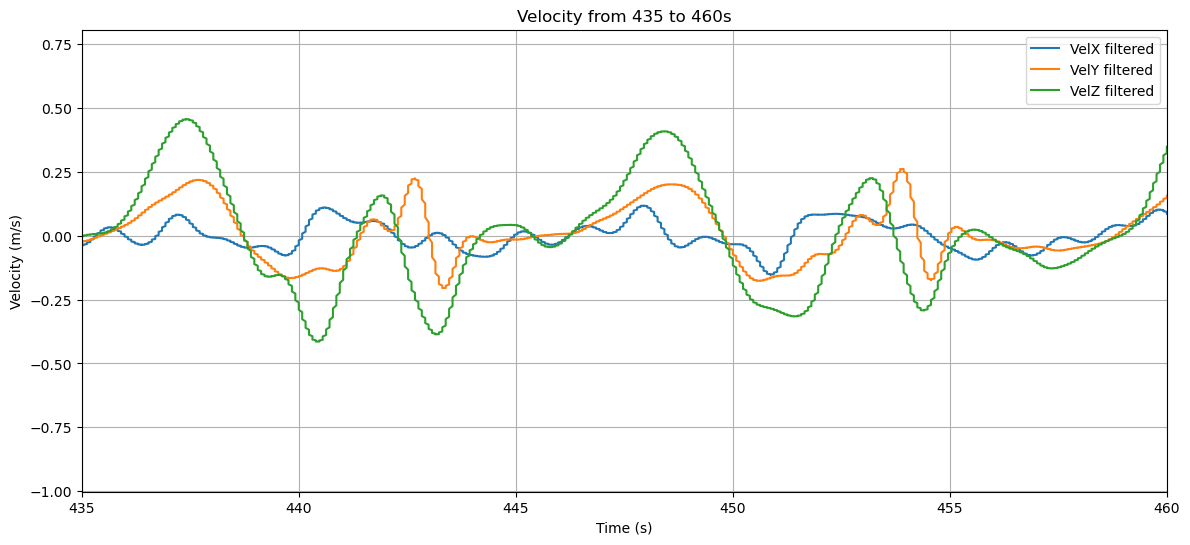

In [67]:
from scipy import integrate

def butter_highpass_filter(data, cutoff=0.1, fs=50, order=4):
    nyq = 0.5 * fs
    norm_cutoff = cutoff / nyq
    b, a = butter(order, norm_cutoff, btype='high', analog=False)
    return filtfilt(b, a, data)

filtered_accX_ch = butter_highpass_filter(filtered_accX_ch, cutoff=0.1, fs=estimated_hz)
filtered_accY_ch = butter_highpass_filter(filtered_accY_ch, cutoff=0.1, fs=estimated_hz)
filtered_accZ_ch = butter_highpass_filter(filtered_accZ_ch, cutoff=0.1, fs=estimated_hz)
# filtered_accX_wr = butter_highpass_filter(filtered_accX_wr, cutoff=0.1, fs=estimated_hz)
# filtered_accY_wr = butter_highpass_filter(filtered_accY_wr, cutoff=0.1, fs=estimated_hz)
# filtered_accZ_wr = butter_highpass_filter(filtered_accZ_wr, cutoff=0.1, fs=estimated_hz)

# Example for velocity
filtered_velX_ch = integrate.cumulative_trapezoid(filtered_accX_ch, dx=1/estimated_hz, initial=0)
filtered_velY_ch = integrate.cumulative_trapezoid(filtered_accY_ch, dx=1/estimated_hz, initial=0)
filtered_velZ_ch = integrate.cumulative_trapezoid(filtered_accZ_ch, dx=1/estimated_hz, initial=0)

# filtered_velX_wr = integrate.cumulative_trapezoid(filtered_accX_wr, dx=1/estimated_hz)
# filtered_velY_wr = integrate.cumulative_trapezoid(filtered_accY_wr, dx=1/estimated_hz)
# filtered_velZ_wr = integrate.cumulative_trapezoid(filtered_accZ_wr, dx=1/estimated_hz)

#Plot from 435s to 460s
plt.figure(figsize=(14, 6))
plt.plot(df_mad_jonatan_chest['time'], filtered_velX_ch, label='VelX filtered')
plt.plot(df_mad_jonatan_chest['time'], filtered_velY_ch, label='VelY filtered')
plt.plot(df_mad_jonatan_chest['time'], filtered_velZ_ch, label='VelZ filtered')
plt.xlim(435, 460)  # Adjust x-axis limits to zoom in
# plt.ylim(-500, 500)  # Adjust y-axis limits 
plt.title('Velocity from 435 to 460s')
plt.xlabel('Time (s)')
plt.ylabel('Velocity (m/s)')
plt.legend()
plt.grid(True)
plt.show()

### Clean

In [68]:
# print(np.isnan(df_mad_jonatan_chest['AccZ_chest_global']).sum(), np.isnan(df_mad_jonatan_chest['AccY_chest_global']).sum(), np.isnan(df_mad_jonatan_chest['AccX_chest_global']).sum())

In [69]:
# # Drop rows with any NaN in AccX, AccY, or AccZ
# # df_clean = df.dropna(subset=['AccX', 'AccY', 'AccZ'])
# df_clean = df.dropna(subset=['AccX_global', 'AccY_global', 'AccZ_global'])

In [70]:
# Now extract the cleaned arrays and convert to #convert m/s^2 to g using the post-madgwick data
acc_x_chest = df_mad_jonatan_chest['AccX_chest_global'].values/9.81
acc_y_chest = df_mad_jonatan_chest['AccY_chest_global'].values/9.81
acc_z_chest = df_mad_jonatan_chest['AccZ_chest_global'].values/9.81
# acc_x_wrist = df_mad_jonatan_wrist['AccX_wrist_global'].values/9.81
# acc_y_wrist = df_mad_jonatan_wrist['AccY_wrist_global'].values/9.81
# acc_z_wrist = df_mad_jonatan_wrist['AccZ_wrist_global'].values/9.81

### Sum the acceleration

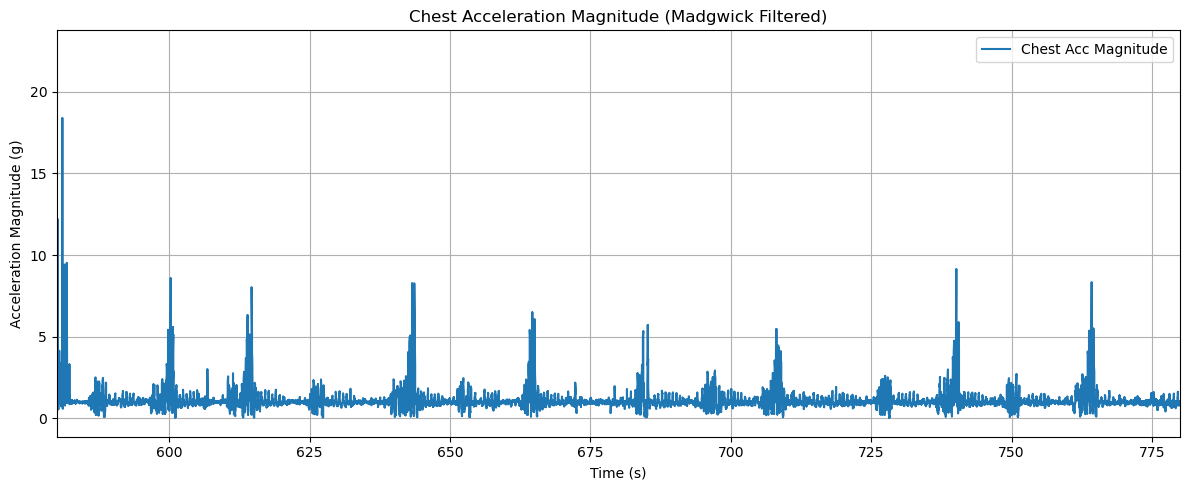

In [71]:
# Rectify acceleration by summing the squares of each axis and taking the square root
df_mad_jonatan_chest['Acc_Mag_chest'] = np.sqrt(acc_x_chest**2 + acc_y_chest**2 + acc_z_chest**2)
# df_mad_jonatan_wrist['Acc_Mag_wrist'] = np.sqrt(acc_x_wrist**2 + acc_y_wrist**2 + acc_z_wrist**2)

# Plot the rectified acceleration
plt.figure(figsize=(12, 5))
plt.plot(df_mad_jonatan_chest['time'], df_mad_jonatan_chest['Acc_Mag_chest'], label='Chest Acc Magnitude')
# plt.plot(df_mad_jonatan_wrist['time'], df_mad_jonatan_wrist['Acc_Mag_wrist'], label='Wrist Acc Magnitude', alpha=0.7) #       more transparent
plt.title("Chest Acceleration Magnitude (Madgwick Filtered)")
plt.xlim(580, 780)  # Adjust x-axis limits to zoom in
plt.xlabel("Time (s)")
plt.ylabel("Acceleration Magnitude (g)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

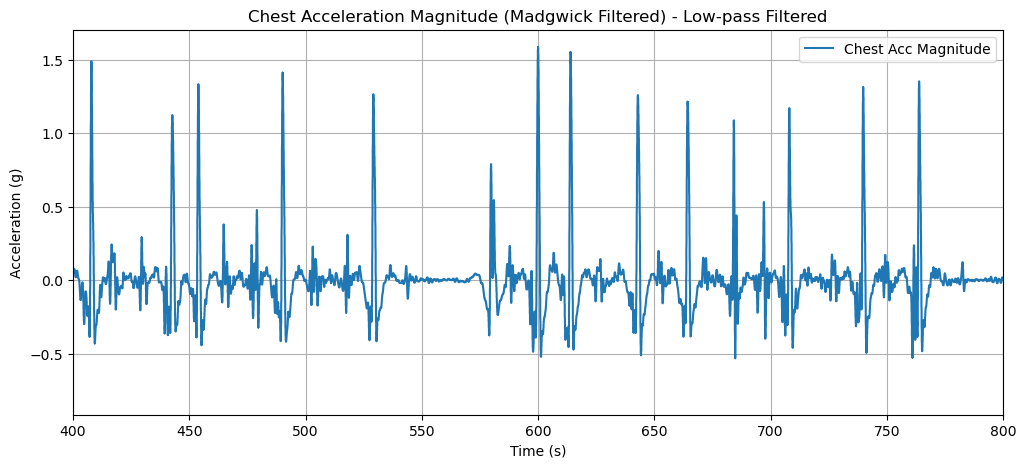

In [72]:
# Low-pass filter the rectified acceleration
filtered_acc_ch = butter_lowpass_filter(df_mad_jonatan_chest['Acc_Mag_chest'], cutoff=1, fs=estimated_hz)
# filtered_acc_wr = butter_lowpass_filter(df_mad_jonatan_wrist['Acc_Mag_wrist'] , cutoff=1, fs=sample_rate)

# High-pass filter the rectified acceleration to remove drift
filtered_acc_ch = butter_highpass_filter(filtered_acc_ch, cutoff=0.1, fs=estimated_hz)
# filtered_acc_wr = butter_highpass_filter(filtered_acc_wr, cutoff=0.1, fs=estimated_hz)

#Plot
plt.figure(figsize=(12, 5))
plt.plot(df_mad_jonatan_chest['time'], filtered_acc_ch, label='Chest Acc Magnitude')
# plt.plot(df_mad_jonatan_wrist['time'], filtered_acc_wr, label='Wrist Acc Magnitude', alpha=0.7) # more transparent
plt.title("Chest Acceleration Magnitude (Madgwick Filtered) - Low-pass Filtered")
plt.xlim(400, 800)  # Adjust x-axis limits to zoom in
plt.xlabel('Time (s)')
plt.ylabel('Acceleration (g)')
plt.legend()
plt.grid(True)
plt.show()

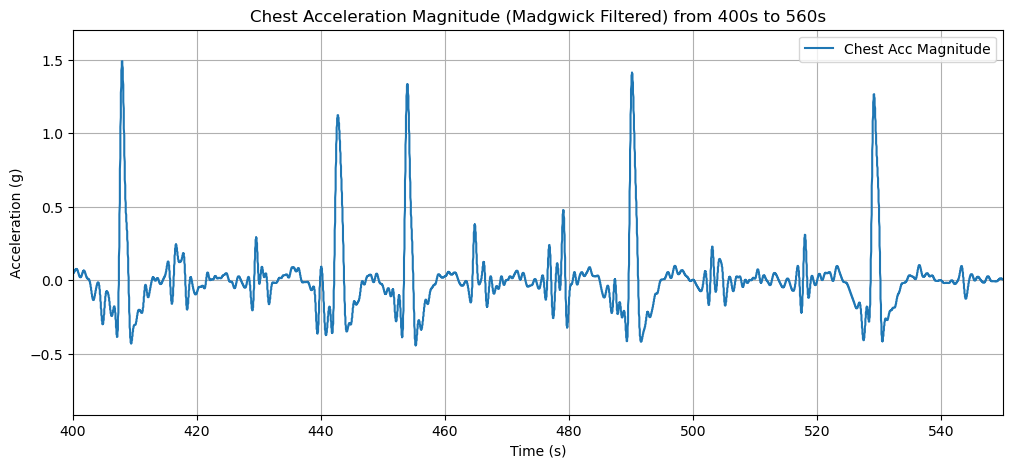

In [ ]:
#Plot from 400s to 550s
plt.figure(figsize=(12, 5))
plt.plot(df_mad_jonatan_chest['time'], filtered_acc_ch, label='Chest Acc Magnitude')
# plt.plot(df_mad_jonatan_wrist['time'], filtered_acc_wr, label='Wrist Acc Magnitude', alpha=0.7) # more transparent
plt.title("Chest Acceleration Magnitude (Madgwick and Band Pass Filtered) from 400s to 560s")
plt.xlim(400, 550)  # Adjust x-axis limits to zoom in
plt.xlabel('Time (s)')
plt.ylabel('Acceleration (g)')
plt.legend()
plt.grid(True)
plt.show()

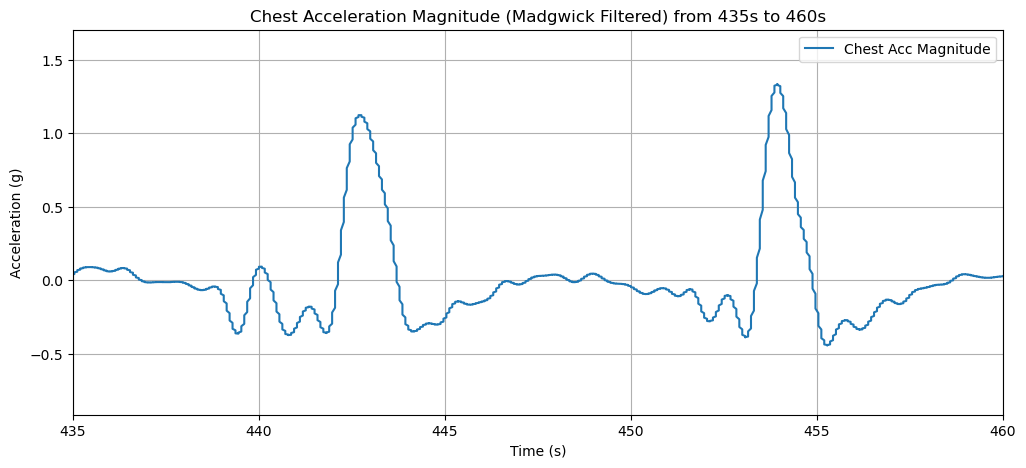

In [ ]:
#Plot from 435s to 460s
plt.figure(figsize=(12, 5))
plt.plot(df_mad_jonatan_chest['time'], filtered_acc_ch, label='Chest Acc Magnitude')
# plt.plot(df_mad_jonatan_wrist['time'], filtered_acc_wr, label='Wrist Acc Magnitude', alpha=0.7) # more transparent
plt.title("Chest Acceleration Magnitude (Madgwick and Band Pass Filtered) from 435s to 460s")
plt.xlim(435, 460)  # Adjust x-axis limits to zoom in
plt.xlabel('Time (s)')
plt.ylabel('Acceleration (g)')
plt.legend()
plt.grid(True)
plt.show()

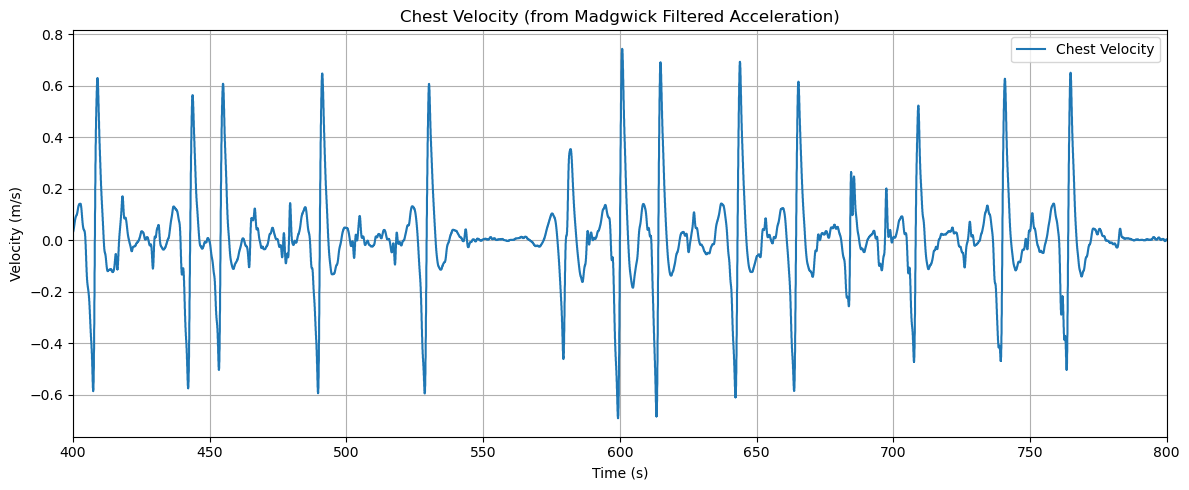

In [75]:
# Trapezoidal integration to get velocity
vel_ch = integrate.cumulative_trapezoid(filtered_acc_ch, dx=1/estimated_hz, initial=0)
# vel_wr = integrate.cumulative_trapezoid(filtered_acc_wr, dx=1/estimated_hz, initial=0)

# Plot the velocity
plt.figure(figsize=(12, 5))
plt.plot(df_mad_jonatan_chest['time'], vel_ch, label='Chest Velocity')
# plt.plot(df_mad_jonatan_wrist['time'], vel_wr, label='Wrist Velocity', alpha=0.7) # more transparent
plt.title("Chest Velocity (from Madgwick Filtered Acceleration)")
plt.xlim(400, 800)  # Adjust x-axis limits to zoom in
plt.xlabel("Time (s)")
plt.ylabel("Velocity (m/s)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

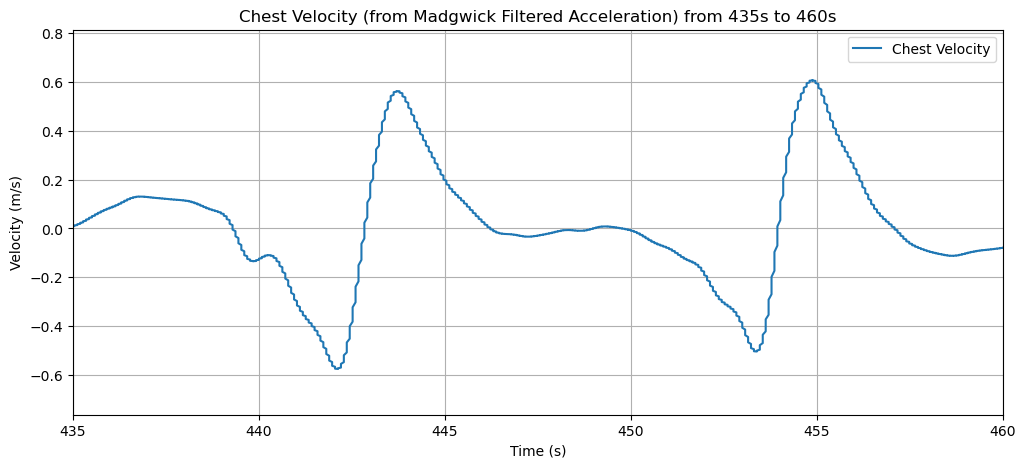

In [77]:
#Plot from 435s to 460s
plt.figure(figsize=(12, 5))
plt.plot(df_mad_jonatan_chest['time'], vel_ch, label='Chest Velocity')
# plt.plot(df_mad_jonatan_wrist['time'], vel_wr, label='Wrist Velocity', alpha=0.7) # more transparent
plt.title("Chest Velocity (from Madgwick Filtered Acceleration) from 435s to 460s")
plt.xlim(435, 460)  # Adjust x-axis limits to zoom in
plt.xlabel('Time (s)')
plt.ylabel('Velocity (m/s)')
plt.legend()
plt.grid(True)
plt.show()

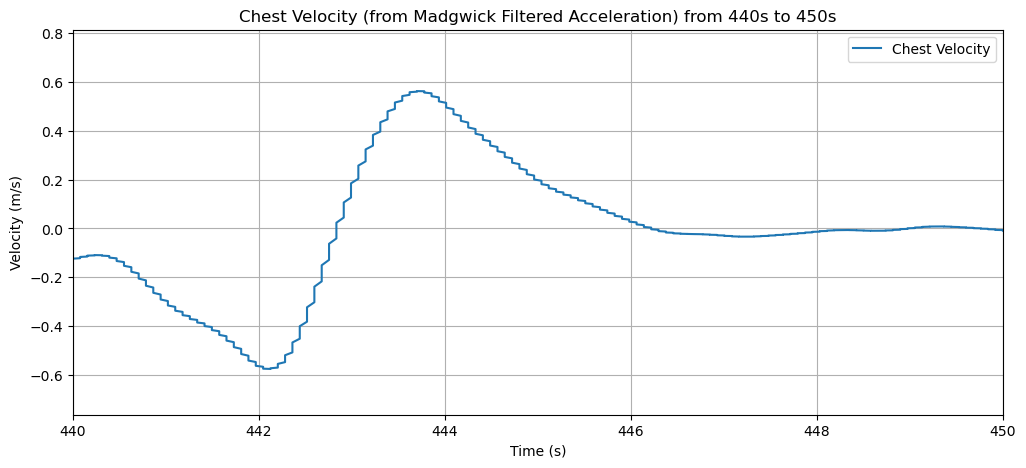

In [79]:
#Plot from 440s to 450s
plt.figure(figsize=(12, 5))
plt.plot(df_mad_jonatan_chest['time'], vel_ch, label='Chest Velocity')
# plt.plot(df_mad_jonatan_wrist['time'], vel_wr, label='Wrist Velocity', alpha=0.7) # more transparent
plt.title("Chest Velocity (from Madgwick Filtered Acceleration) from 440s to 450s")
plt.xlim(440, 450)  # Adjust x-axis limits to zoom in
plt.xlabel('Time (s)')
plt.ylabel('Velocity (m/s)')
plt.legend()
plt.grid(True)
plt.show()

### Zero velocity update

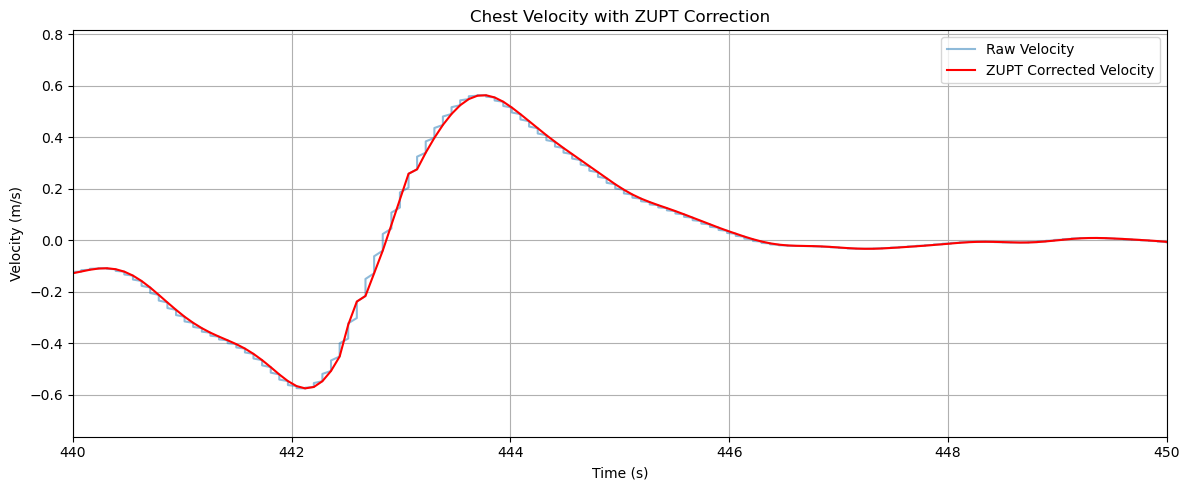

In [84]:
# Zero-Velocity Update (ZUPT) Implementation

# Detect stance (accel magnitude close to 1g)
stance = pd.Series(filtered_acc_ch).between(0.90, 1.10)  # returns boolean mask

# Apply ZUPT
vel_corrected = vel_ch.copy()
vel_corrected[stance] = 0.0  # reset where we know subject is still

# Optionally interpolate in/out of stance to avoid discontinuities
from scipy.interpolate import interp1d
not_stance = ~stance
interp_func = interp1d(df_mad_jonatan_chest['time'][not_stance], vel_corrected[not_stance], 
                       bounds_error=False, fill_value="extrapolate")
vel_corrected = interp_func(df_mad_jonatan_chest['time'])

# Plot the corrected velocity
plt.figure(figsize=(12, 5))
plt.plot(df_mad_jonatan_chest['time'], vel_ch, label='Raw Velocity', alpha=0.5)
plt.plot(df_mad_jonatan_chest['time'], vel_corrected, label='ZUPT Corrected Velocity', color='red')
plt.title("Chest Velocity with ZUPT Correction")
plt.xlim(440, 450)  # Adjust x-axis limits to zoom in
plt.xlabel("Time (s)")
plt.ylabel("Velocity (m/s)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Find peaks

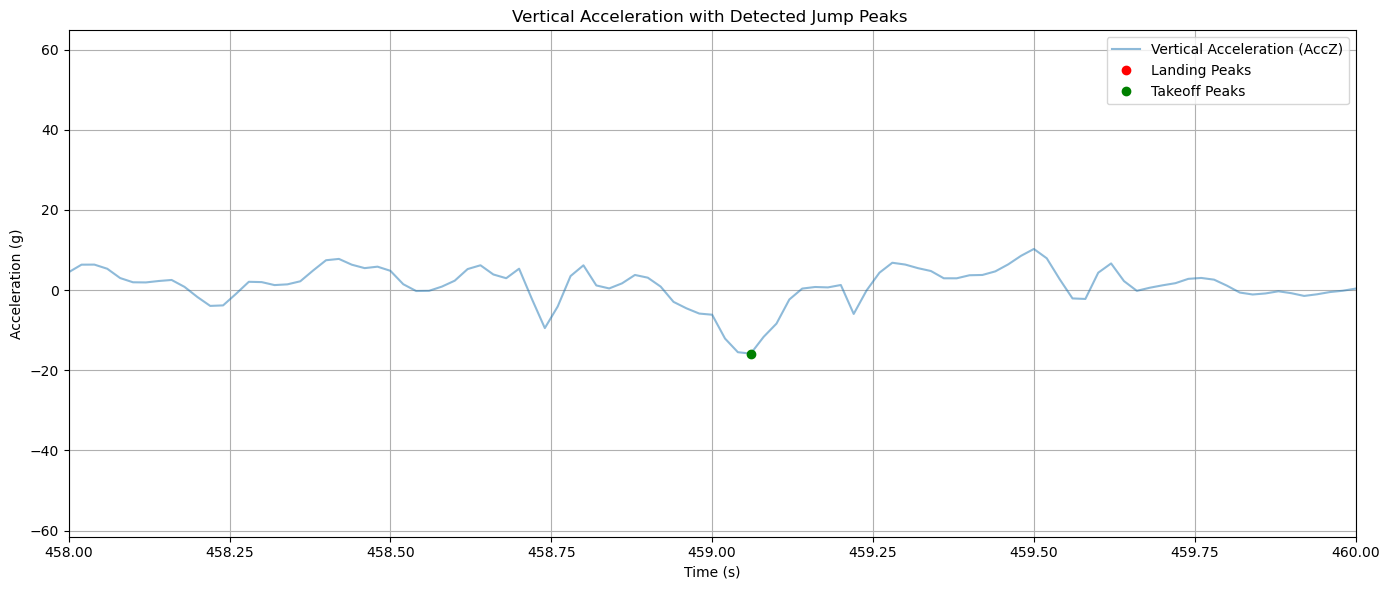

In [ ]:
# Detecting peaks for jump events
from scipy.signal import find_peaks 

# Detect peaks (landings: high +ve AccZ, takeoffs: high -ve AccZ)
peaks_positive, _ = find_peaks(acc_z, height=15, distance=20)
peaks_negative, _ = find_peaks(-acc_z, height=15, distance=20)

# Plot data in selected range
start_time = 458
end_time = 460
mask = (df_clean['time'] >= start_time) & (df_clean['time'] <= end_time)

plt.figure(figsize=(14, 6))
plt.plot(df_clean['time'][mask], acc_z[mask], label='Vertical Acceleration (AccZ)', alpha=0.5)
plt.xlim(458, 460)  # Adjust x-axis limits to zoom in
plt.plot(df_clean['time'].iloc[peaks_positive], acc_z[peaks_positive], 'ro', label='Potential landing Peaks')
plt.plot(df_clean['time'].iloc[peaks_negative], acc_z[peaks_negative], 'go', label='Potential takeoff Peaks')
plt.title(f"Vertical Acceleration with Detected Jump Peaks ")
plt.xlabel("Time (s)")
plt.ylabel("Acceleration (g)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Identifying jumps

/var/folders/90/zl66g5qj47l1drgbk3nfzk_40000gn/T/ipykernel_57333/3564007297.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['is_jump'] = 0


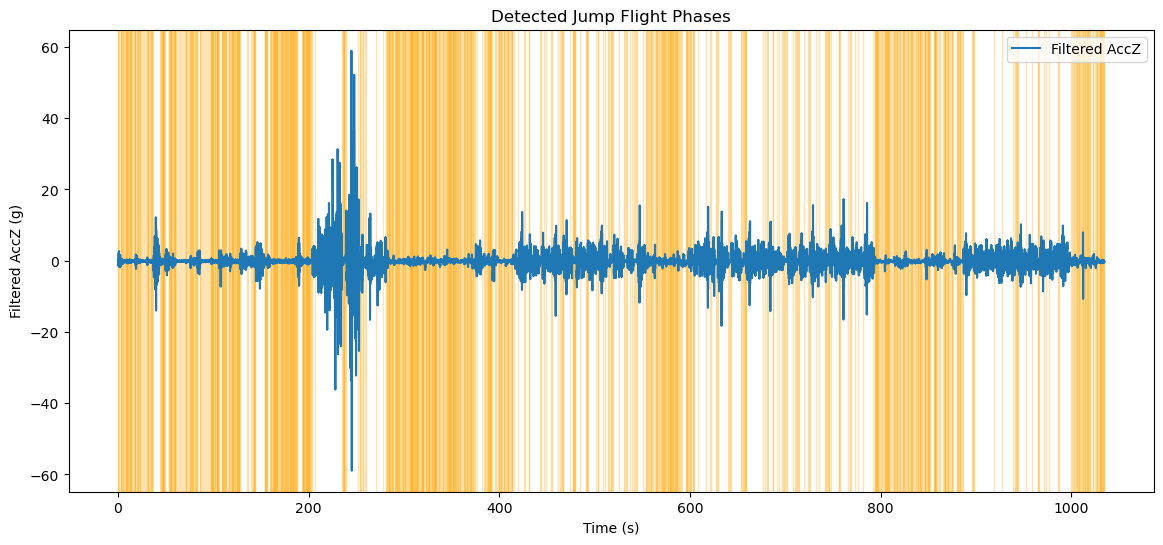

In [ ]:
threshold = 0.5 # in g, threshold for detecting flight phase
min_duration = 0.2  # seconds
min_samples = int(min_duration * sample_rate)

# Find where abs(filtered_acc_z) < threshold
flight_mask = np.abs(filtered_acc_z) < threshold

# Find continuous regions (epochs) where flight_mask is True
from scipy.ndimage import label

labels, num = label(flight_mask) #
jump_epochs = []
for i in range(1, num+1):
    idx = np.where(labels == i)[0]
    if len(idx) >= min_samples:
        jump_epochs.append((idx[0], idx[-1]))

# Mark jumps in DataFrame
df_clean['is_jump'] = 0
for start, end in jump_epochs:
    df_clean.iloc[start:end+1, df_clean.columns.get_loc('is_jump')] = 1

# Optional: Plot detected flight phases
plt.figure(figsize=(14, 6))
plt.plot(df_clean['time'], filtered_acc_z, label='Filtered AccZ')
for start, end in jump_epochs:
    plt.axvspan(df_clean['time'].iloc[start], df_clean['time'].iloc[end], color='orange', alpha=0.3)
plt.title('Detected Jump Flight Phases')
plt.xlabel('Time (s)')
plt.ylabel('Filtered AccZ (g)')
plt.legend()
plt.show()

### Build model for identifying jumps 

In [102]:
#List of detected flight phases (start and end indices)
jump_epochs

[(np.int64(0), np.int64(10)),
 (np.int64(18), np.int64(29)),
 (np.int64(140), np.int64(152)),
 (np.int64(161), np.int64(175)),
 (np.int64(181), np.int64(235)),
 (np.int64(239), np.int64(262)),
 (np.int64(267), np.int64(278)),
 (np.int64(296), np.int64(421)),
 (np.int64(424), np.int64(434)),
 (np.int64(436), np.int64(490)),
 (np.int64(492), np.int64(503)),
 (np.int64(521), np.int64(631)),
 (np.int64(633), np.int64(658)),
 (np.int64(675), np.int64(695)),
 (np.int64(697), np.int64(876)),
 (np.int64(879), np.int64(889)),
 (np.int64(892), np.int64(903)),
 (np.int64(907), np.int64(919)),
 (np.int64(993), np.int64(1004)),
 (np.int64(1023), np.int64(1033)),
 (np.int64(1049), np.int64(1151)),
 (np.int64(1156), np.int64(1510)),
 (np.int64(1552), np.int64(1570)),
 (np.int64(1573), np.int64(1584)),
 (np.int64(1589), np.int64(1709)),
 (np.int64(1712), np.int64(1756)),
 (np.int64(1761), np.int64(1771)),
 (np.int64(1774), np.int64(1846)),
 (np.int64(2221), np.int64(2230)),
 (np.int64(2245), np.int64(

In [103]:
#Calculate velocity
from scipy.integrate import cumulative_trapezoid as cumtrapz
from scipy.signal import detrend

# Convert vertical acceleration to net acceleration by subtracting the median vertical acceleration (approx. 1g)
net_acc_z = filtered_acc_z - 1  # in g 

net_acc_z = detrend(net_acc_z)  # Remove linear trend

# Integrate net acceleration to get velocity using cumulative trapezoidal integration
velocity_z = cumtrapz(net_acc_z * 9.81, dx=1/sample_rate, initial=0)  # in m/s



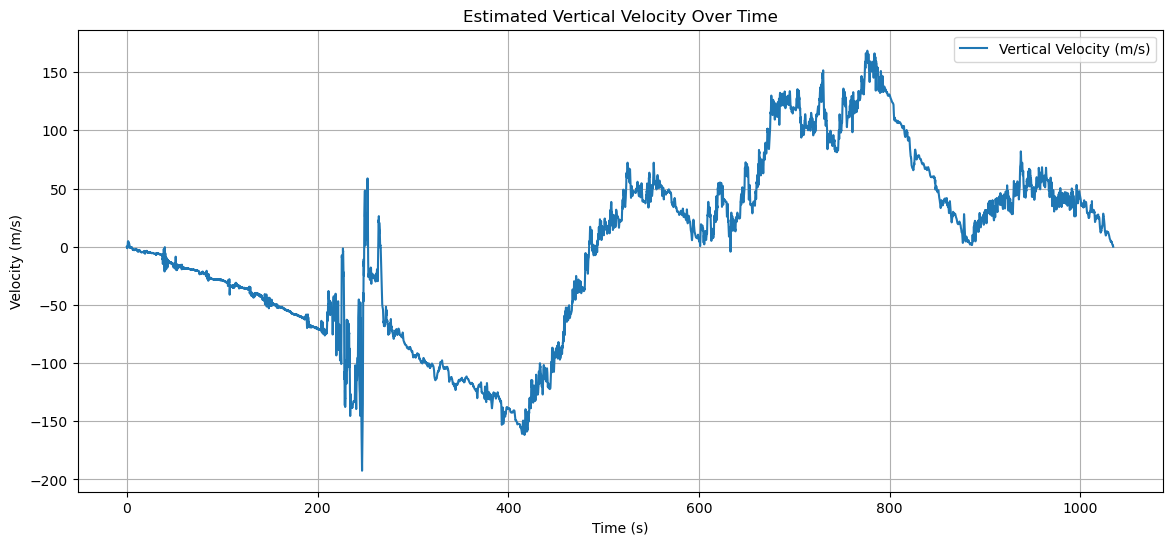

In [104]:
# plot velocity
plt.figure(figsize=(14, 6))
plt.plot(df_clean['time'], velocity_z, label='Vertical Velocity (m/s)')
plt.title('Estimated Vertical Velocity Over Time')
plt.xlabel('Time (s)')
plt.ylabel('Velocity (m/s)')
plt.legend()
plt.grid(True)
plt.show()  

/opt/miniconda3/envs/imu_logger/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/miniconda3/envs/imu_logger/lib/python3.10/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


ValueError: At least one point is required along `axis`.

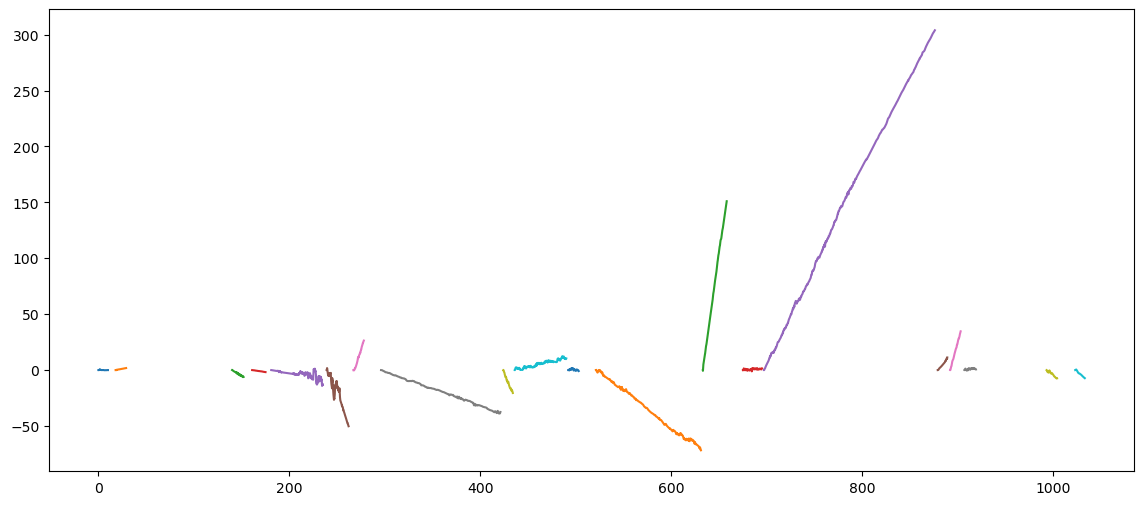

In [ ]:
# #Zero velocity update (ZUPT) during detected flight phases

# #Loop through each jump window and integrate velocity with reset
# plt.figure(figsize=(14, 6))

# for i, (start_t, end_t) in enumerate(jump_epochs):
#     mask = (df_clean['time'] >= start_t) & (df_clean['time'] <= end_t)
    
#     # Time and acceleration segment
#     t_seg = df_clean['time'][mask].values
#     acc_seg = net_acc_z[mask]

#     # Remove static bias from each segment (baseline)
#     acc_seg = acc_seg - np.mean(acc_seg[:10])  # assume first ~10 samples are static

#     # Integrate with zero initial velocity
#     vel_seg = cumtrapz(acc_seg, dx=1/sample_rate, initial=0)

#     # Plot
#     plt.plot(t_seg, vel_seg, label=f'Jump {i+1}')

# plt.title('Vertical Velocity of Detected Jumps (Reset Per Event)')
# plt.xlabel('Time (s)')
# plt.ylabel('Vertical Velocity (m/s)')
# plt.grid(True)
# plt.legend()
# plt.tight_layout()
# plt.show()

### Feature extraction

In [107]:
from scipy.stats import skew, kurtosis

# Window settings
window_size = int(sample_rate * 1.0)  # 1 second
stride = int(sample_rate * 0.25)      # 75% overlap

features = []
timestamps = []

for start in range(0, len(df) - window_size, stride):
    end = start + window_size
    window = filtered_acc_z[start:end]

    ts = df['time'].iloc[start]
    
    features.append([
        np.mean(window),
        np.std(window),
        np.max(window),
        np.min(window),
        np.ptp(window),            # Peak-to-peak
        np.argmax(window),         # Index of peak
        np.argmin(window),         # Index of trough
        skew(window),
        kurtosis(window),
        velocity_z[start:end].mean()  # Average velocity in the window
    ])
    timestamps.append(ts)




In [110]:
# Create DataFrame
X = pd.DataFrame(features, columns=[
    'mean', 'std', 'max', 'min', 'ptp', 'argmax', 'argmin', 'skew', 'kurtosis', 'mean_velocity'
])


In [111]:
def is_in_jump_window(t, windows):
    for start, end in windows:
        if start <= t <= end:
            return 1
    return 0

y = [is_in_jump_window(t, jump_epochs) for t in timestamps]


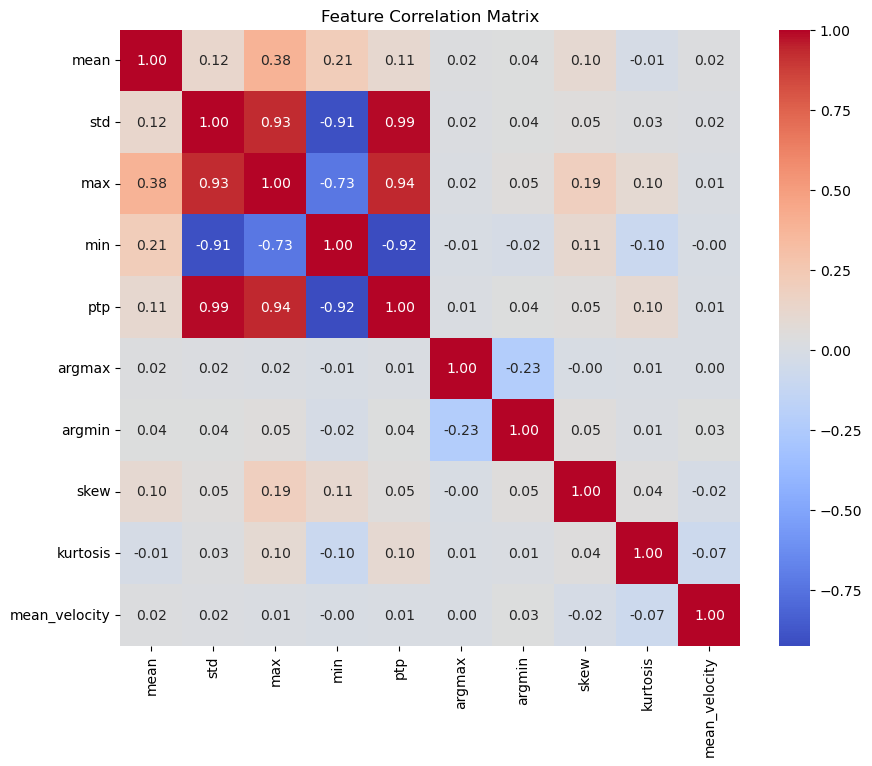

<Figure size 640x480 with 0 Axes>

In [112]:
# Feature correlation matrix
import seaborn as sns
plt.figure(figsize=(10, 8))
corr = X.corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Feature Correlation Matrix")
plt.show()
plt.tight_layout()  

In [113]:
#Evaluate model

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix 

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



In [114]:
# Train model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train) 

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


### Fuse Gyro data and filter 

In [ ]:
import imufusion

# Create a new AHRS filter object
ahrs = imufusion.Ahrs()
ahrs.settings = imufusion.Settings(100)  # Set sample rate to 100 Hz    
ahrs.settings.acceleration_rejection = 0.1  # Adjust as needed
ahrs.settings.gyro_rejection = 0.1  # Adjust as needed
ahrs.settings.magnetic_rejection = 0.1  # Adjust as needed
ahrs.settings.gyro_bias_correction = True

